## Setting up file name

In [22]:
import os
path = '/Users/astridvacher/SSE/Centuri Summer School documents/Neuroscience project/2022_CENTURI-SummerSchool-main/datasets/dataset1_reaching-task'
fname = os.path.join(path, 'Dataset1.mat')
from scipy.io import loadmat
DATA = loadmat(fname)

## Import necessary libraries

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [30]:
R = DATA['R']
R = R.transpose()
direction = DATA['direction']

In [31]:
DATA['R'].shape

(143, 158)

In [32]:
DATA.keys()

dict_keys(['__header__', '__version__', '__globals__', 'direction', 'R'])

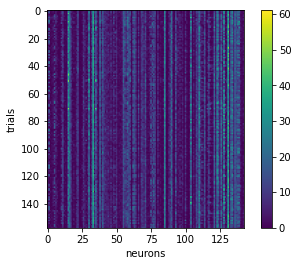

In [33]:
plt.imshow(R)
plt.xlabel('neurons')
plt.ylabel('trials')
plt.colorbar()
plt.show()

Choose the mean of trials depending on direction

In [34]:
#Extract the different directions
R_mean = np.zeros((143, 8))
for direction_ in range(8):
    R_mean[:, direction_] = R[np.where(direction==direction_+1)[0], :].mean(axis=0)

Plot the results : mean of each direction for the first neurone

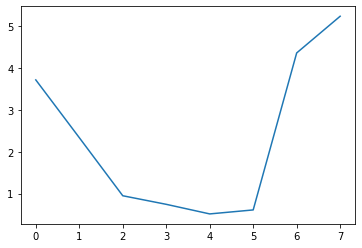

In [35]:
plt.plot(R_mean[0,:])

## Fitting Von Mises Curves for each neuron

In [205]:
def tuning_function(x, mu, kappa, fmax, bsl):
    # Von Mises, with kappa the concentration, mu the location
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = bsl + np.exp(kappa*(np.cos(x-mu)-1)) * (fmax-bsl)
    return tf

from lmfit import Model, Parameters

def fit_tc(array, init_kappa):
    x = np.linspace(0, 2*np.pi, len(array), endpoint=False)

    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('mu', x[np.argmax(array)], True, 0., 2*np.pi),
                  ('kappa', init_kappa, True,  .1, 5.),
                  ('fmax', np.max(array), True, 0.01, 2*np.max(array)+5),
                 ('bsl', np.min(array), True, 0.0, np.max(array)+5))
    out = mod.fit(array, pars, x=x, nan_policy='omit', max_nfev=50000)

    return out.best_values

In [206]:
values_n1 = fit_tc(R_mean[0,:],2)
theta = np.linspace(0,2*np.pi,len(R_mean[0,:]),endpoint=False)

fitted_VM1 = tuning_function(theta,values_n1['mu'],values_n1['kappa'],values_n1['fmax'],values_n1['bsl'])


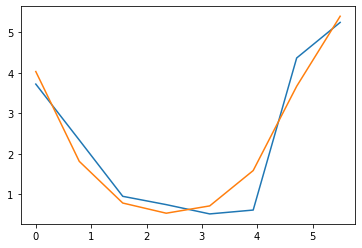

In [207]:
plt.plot(theta,R_mean[0,:])
plt.plot(theta,fitted_VM1)

In [208]:
values = np.zeros((143,4))
fit_VM = np.zeros((143,8))

for i in range(143):
    values[i,:] = np.array(list(fit_tc(R_mean[i,:],2).values()))
    fit_VM[i,:]=tuning_function(theta,values[i,0],values[i,1],values[i,2],values[i,3])
    
def plot_fitting(i):
    plt.plot(theta,R_mean[i,:])
    plt.plot(theta,fit_VM[i,:])

In [209]:
fit_VM

array([[ 4.0277961 ,  1.81207858,  0.78393231, ...,  1.58528735,
         3.66443033,  5.39195404],
       [ 1.93516872,  4.95037755, 14.34234308, ...,  7.57213857,
         2.61358584,  1.485304  ],
       [ 2.07543115,  1.6229422 ,  1.07012882, ...,  0.90665182,
         1.3750153 ,  1.9377012 ],
       ...,
       [ 3.27791845,  3.28073233,  3.41600704, ...,  3.40858986,
         3.28057079,  3.27791398],
       [ 0.793422  ,  0.85085353,  1.47747811, ...,  0.7926989 ,
         0.79217306,  0.79219283],
       [ 3.56099286,  2.55639856,  1.780369  , ...,  2.30485112,
         3.30949263,  3.96294506]])

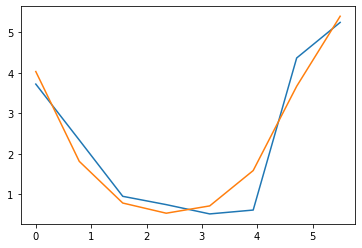

In [210]:
plot_fitting(0)

(array([17.,  4., 13., 24., 24., 14.,  8.,  8., 13., 18.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

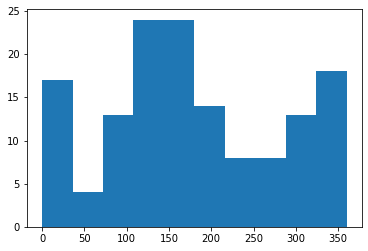

In [211]:

plt.hist(values[:,0]*180/np.pi,)

(array([39., 21., 18., 12.,  2.,  2.,  5.,  2.,  1., 41.]),
 array([0.10000002, 0.59000002, 1.08000001, 1.57000001, 2.06000001,
        2.55000001, 3.04000001, 3.53000001, 4.02      , 4.51      ,
        5.        ]),
 <BarContainer object of 10 artists>)

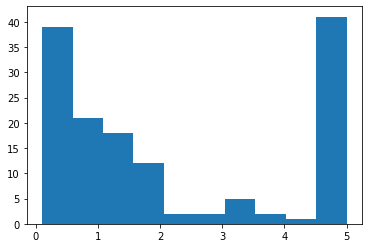

In [212]:
plt.hist(values[:,1])

(array([90., 12., 41.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.        ,   2.04081633,   4.08163265,   6.12244898,
          8.16326531,  10.20408163,  12.24489796,  14.28571429,
         16.32653061,  18.36734694,  20.40816327,  22.44897959,
         24.48979592,  26.53061224,  28.57142857,  30.6122449 ,
         32.65306122,  34.69387755,  36.73469388,  38.7755102 ,
         40.81632653,  42.85714286,  44.89795918,  46.93877551,
         48.97959184,  51.02040816,  53.06122449,  55.10204082,
         57.14285714,  59.18367347,  61.2244898 ,  63.26530612,
         65.30612245,  67.34693878,  69.3877551 ,  71.42857143,
         73.46938776,  75.51020408,  77.55102041,  79.59183673,
         81.63265306,  83.67346939,  85.71428571,  87.75510204,
         89.79591

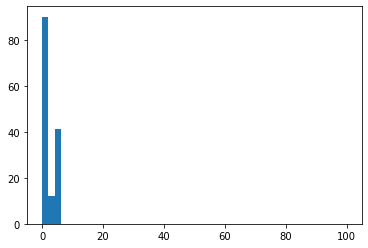

In [218]:
binsKappa = np.linspace(0,100,50)
plt.hist(values[:,1],bins = binsKappa)

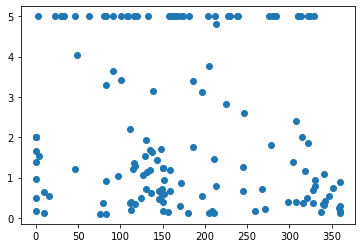

In [214]:
plt.scatter(values[:,0]*180/np.pi,values[:,1])

In [215]:
np.argmax(values[:,1])

86

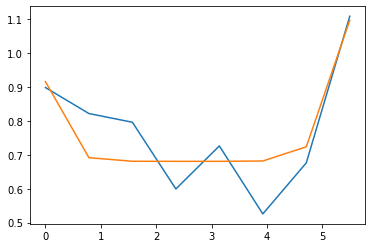

In [217]:
plot_fitting(86)